### Preparation steps

Install iotfunctions with

`pip install git+https://github.com/ibm-watson-iot/functions@development`

This projects contains the code for the Analytics Service pipeline as well as the anomaly functions and should pull in most of this notebook's dependencies.

The plotting library matplotlib is the exception, so you need to run
`pip install matplotlib`


In [318]:
# Real life data

import logging
import threading
import itertools
import pandas as pd  
import numpy as np  
import json
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.dbtables import FileModelStore
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from mmfunctions.anomaly import (SaliencybasedGeneralizedAnomalyScore, SpectralAnomalyScoreExt,
                 FFTbasedGeneralizedAnomalyScore, KMeansAnomalyScore, KDEAnomalyScore,
                 SaliencybasedGeneralizedAnomalyScoreV2, FFTbasedGeneralizedAnomalyScoreV2, 
                 KMeansAnomalyScoreV2)                 
import datetime as dt

from skimage import util as skiutil
import scipy as sp

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.INFO)

In [11]:
# setting to make life easier
Temperature='Temperature'
kmeans0='TemperatureKmeansScore0'
kmeans='TemperatureKmeansScore'
fft0='FFTAnomalyScore0'
mat0='MatrixProfileAnomalyScore'
fft='FFTAnomalyScore'
spectral='TemperatureSpectralScore'
spectralinv='TemperatureSpectralScoreInv'
sal='SaliencyAnomalyScore'
gen='TemperatureGeneralizedScore'
kmeansA='kmeansAnomaly'
kmeansA0='kmeansAnomaly0'
spectralA='spectralAnomaly'
fftA0='fftAnomaly0'
fftA='fftAnomaly'
salA='salAnomaly'
genA='genAnomaly'
matA0='matAnomaly'

kmeans_break=1.3
spectral_break = 100
fft_break = 100
sal_break = 100
gen_break = 30000
mat_break = 1


In [12]:
# set up a db object with a FileModelStore to support scaling
#with open('credentials_as_monitor_demo.json', encoding='utf-8') as F:
#    credentials = json.loads(F.read())
#db_schema=None
#fm = FileModelStore()
#db = Database(credentials=credentials, model_store=fm)
#print (db)

db_schema=None
class DatabaseDummy:
    tenant_id = '###_IBM_###'
    db_type = 'db2'
    model_store = FileModelStore()
    def _init(self):
        return

db = DatabaseDummy()
        
print (db.tenant_id)

2021-01-20T10:28:25.297 INFO iotfunctions.dbtables.__init__ Init FileModelStore
###_IBM_###


### Intercooler Temperature data

In [13]:
# Run on the good pump first 
# Get stuff in
df_i = pd.read_csv('./AI_Data/Intercooler Temp.csv', index_col=False, parse_dates=['t_stamp'])
#t_stamp,CA1/CDA/AC_Comp1/InterCoolTemp


df_i['entity']='CA1_CDA_AC_Comp1_InterCoolTemp'  # NO SLASHES IN FILESYSTEM !
df_i.rename(columns={'t_stamp':'timestamp', 'CA1/CDA/AC_Comp1/InterCoolTemp':'Temperature'}, inplace=True)

# and sort it by timestamp
df_i = df_i.sort_values(by='timestamp')
df_i = df_i.set_index(['entity','timestamp']).dropna()

df_i.head(2)

Temperature
entity                         timestamp                       
CA1_CDA_AC_Comp1_InterCoolTemp 2021-01-11 02:00:00     0.231542
                               2021-01-11 02:00:00     0.231547

#### Running Monitor's anomaly functions

In [15]:
# Now run the anomaly functions as if they were executed in a pipeline

jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}


spsi = SpectralAnomalyScoreExt(Temperature, 12, spectral, spectralinv)
et = spsi._build_entity_type(columns = [Column(Temperature,Float())], **jobsettings)
spsi._entity_type = et
df_i = spsi.execute(df=df_i)

sali = SaliencybasedGeneralizedAnomalyScoreV2(Temperature, 12, True, sal)
et = sali._build_entity_type(columns = [Column(Temperature,Float())], **jobsettings)
sali._entity_type = et
df_i = sali.execute(df=df_i)


ffti0 = FFTbasedGeneralizedAnomalyScoreV2(Temperature, 12, True, fft0)
et = ffti0._build_entity_type(columns = [Column(Temperature,Float())], **jobsettings)
ffti0._entity_type = et
df_i = ffti0.execute(df=df_i)

#EngineLogging.configure_console_logging(logging.DEBUG)
ffti = FFTbasedGeneralizedAnomalyScoreV2(Temperature, 12, True, fft)
et = ffti._build_entity_type(columns = [Column(Temperature,Float())], **jobsettings)
ffti._entity_type = et
df_i = ffti.execute(df=df_i)
#EngineLogging.configure_console_logging(logging.INFO)

kmi0 = KMeansAnomalyScore(Temperature, 12, kmeans0)
et = kmi0._build_entity_type(columns = [Column(Temperature,Float())], **jobsettings)
kmi0._entity_type = et
df_i = kmi0.execute(df=df_i)

#mati0 = MatrixProfileAnomalyScore(Temperature, 12, mat0)
#et = mati0._build_entity_type(columns = [Column(Temperature,Float())], **jobsettings)
#mati0._entity_type = et
#df_i = mati0.execute(df=df_i)
#print (df_i.columns)

kmi = KMeansAnomalyScoreV2(Temperature, 12, True, kmeans)
et = kmi._build_entity_type(columns = [Column(Temperature,Float())], **jobsettings)
kmi._entity_type = et
df_i = kmi.execute(df=df_i)

df_i.describe()

2021-01-20T10:28:45.579 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2021-01-20T10:28:45.621 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2021-01-20T10:28:45.626 ERROR iotfunctions.base.get_bucket_name Could not find credentials for entity type. COS read/write is disabled 
2021-01-20T10:28:45.627 INFO iotfunctions.base.get_models_for_training predicting target SaliencyAnomalyScore
2021-01-20T10:28:45.628 INFO iotfunctions.dbtables.retrieve_model Model model.TEST_ENTITY_FOR_SALIENCYBASEDGENERALIZEDANOMALYSCOREV2.SaliencybasedGeneralizedAnomalyScoreV2.SaliencyAnomalyScore.CA1_CDA_AC_Comp1_InterCoolTemp of size 1176 bytes has been retrieved from filesystem
2021-01-20T10:28:45.629 INFO iotfunctions.base.get_models_for_training load model {
 "name": "model.TEST

/home/markus/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


2021-01-20T10:29:01.506 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2021-01-20T10:29:01.513 ERROR iotfunctions.base.get_bucket_name Could not find credentials for entity type. COS read/write is disabled 
2021-01-20T10:29:01.514 INFO iotfunctions.base.get_models_for_training predicting target TemperatureKmeansScore
2021-01-20T10:29:01.515 INFO iotfunctions.dbtables.retrieve_model Model model.TEST_ENTITY_FOR_KMEANSANOMALYSCOREV2.KMeansAnomalyScoreV2.TemperatureKmeansScore.CA1_CDA_AC_Comp1_InterCoolTemp of size 1146 bytes has been retrieved from filesystem
2021-01-20T10:29:01.516 INFO iotfunctions.base.get_models_for_training load model {
 "name": "model.TEST_ENTITY_FOR_KMEANSANOMALYSCOREV2.KMeansAnomalyScoreV2.TemperatureKmeansScore.CA1_CDA_AC_Comp1_InterCoolTemp",
 "target": "TemperatureKmeansScore",
 "features": [
  "Temperature"
 ],
 "estimator_name": "standard_scaler"

/home/markus/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


2021-01-20T10:29:12.734 INFO mmfunctions.anomaly.execute Standard_Scaler: Found columns Index(['Temperature', 'TemperatureSpectralScore',
       'TemperatureSpectralScoreInv', 'predicted_SaliencyAnomalyScore',
       'SaliencyAnomalyScore', 'predicted_FFTAnomalyScore0',
       'FFTAnomalyScore0', 'predicted_FFTAnomalyScore', 'FFTAnomalyScore',
       'TemperatureKmeansScore0', 'predicted_TemperatureKmeansScore',
       'TemperatureKmeansScore'],
      dtype='object')


,Temperature,TemperatureSpectralScore,TemperatureSpectralScoreInv,predicted_SaliencyAnomalyScore,SaliencyAnomalyScore,predicted_FFTAnomalyScore0,FFTAnomalyScore0,predicted_FFTAnomalyScore,FFTAnomalyScore,TemperatureKmeansScore0,predicted_TemperatureKmeansScore,TemperatureKmeansScore
count,6293.000000,6293.000000,6293.000000,6.293000e+03,6293.000000,6.293000e+03,6293.000000,6.293000e+03,6293.000000,6293.000000,6.293000e+03,6293.000000
mean,8.722680,28.998160,0.289967,1.580740e-17,3477.746824,1.580740e-17,3213.937623,1.580740e-17,3563.546024,21.897873,1.580740e-17,1.138309
std,19.177495,16.898014,0.928633,1.000079e+00,5420.327698,1.000079e+00,5330.532011,1.000079e+00,5556.922638,17.076404,1.000079e+00,0.891599
min,-9.355080,0.058637,0.146498,-9.427298e-01,0.949740,-9.427298e-01,1.171838,-9.427298e-01,0.949486,1.054048,-9.427298e-01,0.057345
25%,-9.021487,17.815754,0.146504,-9.253334e-01,12.880201,-9.253334e-01,14.912492,-9.253334e-01,12.903858,8.174868,-9.253334e-01,0.432067
50%,0.203056,27.917478,0.146504,-4.442865e-01,320.488490,-4.442865e-01,311.150127,-4.442865e-01,326.920419,13.765307,-4.442865e-01,0.702361
75%,36.564583,37.292161,0.146504,1.451916e+00,5934.306549,1.451916e+00,4420.344775,1.451916e+00,6074.774976,35.762342,1.451916e+00,1.859377
max,38.406590,123.269311,6.825753,1.547974e+00,18477.417589,1.547974e+00,18884.805983,1.547974e+00,18962.535525,79.019842,1.547974e+00,4.118315


In [17]:
# Simplify our pandas dataframe to prepare input for plotting
EngineLogging.configure_console_logging(logging.INFO)

df_inputm2 = df_i.loc[['CA1_CDA_AC_Comp1_InterCoolTemp']]
df_inputm2.reset_index(level=[0], inplace=True)
predKM = 'predicted_TemperatureKmeansScore'
predFFT = 'predicted_FFTAnomalyScore'

### All our anomaly scorers go nuts

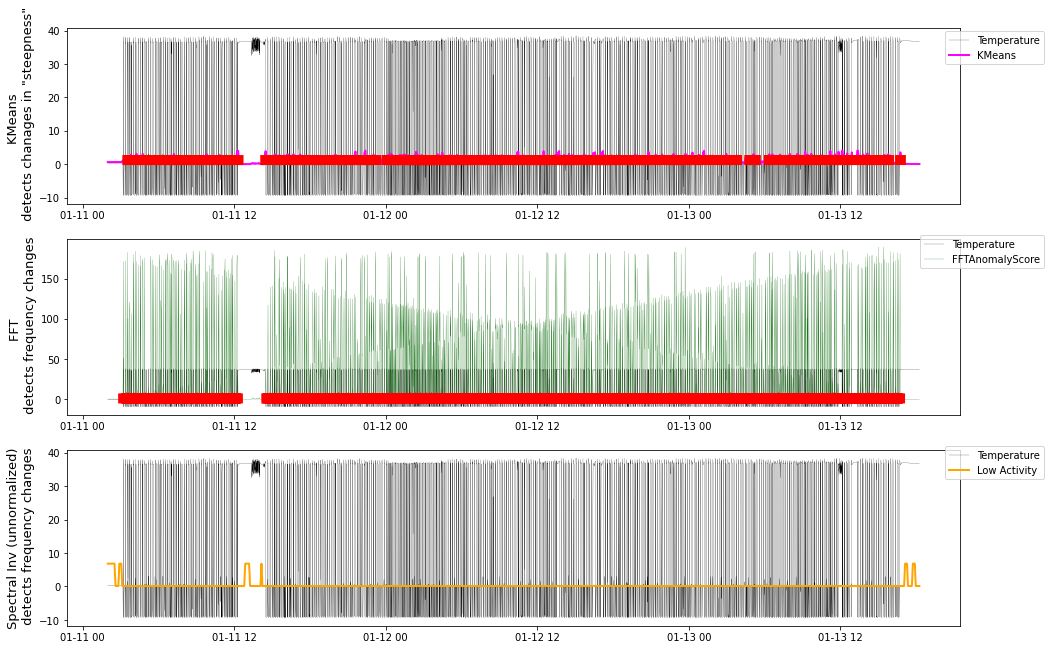

In [146]:
df_inputm2[kmeansA] = df_inputm2[kmeans]
df_inputm2[kmeansA].values[df_inputm2[kmeansA] < kmeans_break] = np.nan
df_inputm2[kmeansA].values[df_inputm2[kmeansA] > kmeans_break] = kmeans_break

df_inputm2[kmeansA0] = df_inputm2[kmeans0]
df_inputm2[kmeansA0].values[df_inputm2[kmeansA0] < kmeans_break] = np.nan
df_inputm2[kmeansA0].values[df_inputm2[kmeansA0] > kmeans_break] = kmeans_break

df_inputm2[fftA] = df_inputm2[fft]
df_inputm2[fftA].values[df_inputm2[fftA] < fft_break] = np.nan
df_inputm2[fftA].values[df_inputm2[fftA] > fft_break] = fft_break

df_inputm2[fftA0] = df_inputm2[fft0]
df_inputm2[fftA0].values[df_inputm2[fftA0] < fft_break] = np.nan
df_inputm2[fftA0].values[df_inputm2[fftA0] > fft_break] = fft_break

#df_inputm2[matA0] = df_inputm2[mat0]
#df_inputm2[matA0].values[df_inputm2[matA0] < mat_break] = np.nan
#df_inputm2[matA0].values[df_inputm2[matA0] > mat_break] = mat_break


plots = 3

fig, ax = plt.subplots(plots, 1, figsize=(16,11))
cnt = 0
ax[cnt].plot(df_inputm2.index, df_inputm2[Temperature],linewidth=0.2,color='black',label=Temperature)
ax[cnt].plot(df_inputm2.index, df_inputm2[kmeans], linewidth=2, color='magenta',label='KMeans')
ax[cnt].plot(df_inputm2.index, df_inputm2[kmeansA], linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.01))
ax[cnt].set_ylabel('KMeans \n detects chanages in "steepness"',fontsize=13)
cnt = 1
ax[cnt].plot(df_inputm2.index, df_inputm2[Temperature],linewidth=0.2,color='black',label=Temperature)
#ax[cnt].plot(df_inputm2.index, df_inputm2[predFFT]+10,linewidth=1,color='green',label=Temperature)
ax[cnt].plot(df_inputm2.index, df_inputm2[fft]/fft_break, linewidth=0.2,color='darkgreen',label=fft)
ax[cnt].plot(df_inputm2.index, df_inputm2[fftA]/fft_break, linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('FFT \n detects frequency changes', fontsize=13)
cnt = 2
ax[cnt].plot(df_inputm2.index, df_inputm2[Temperature],linewidth=0.2,color='black',label=Temperature)
ax[cnt].plot(df_inputm2.index, df_inputm2[spectralinv], linewidth=2,color='orange',label='Low Activity')
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('Spectral Inv (unnormalized)\n detects frequency changes', fontsize=13)
cnt = 3

#### so let's focus on the low activity 

In [148]:
###### focus on 01/13
df_inputm3 = df_inputm2.loc['2021-01-13':'2021-01-14'].copy()

temperature = df_inputm3[Temperature].values
slices = skiutil.view_as_windows(temperature, window_shape=(12,), step=1)

Islice_list = []
Islice_fft_list = []
for slice in slices:
    Islice_list.append(sp.integrate.simps(slice))  # poor man's integral
    Islice_fft_list.append(sp.fftpack.rfft(slice))
ISlice = np.asarray(Islice_list)
ISliceF = np.asarray(Islice_fft_list)


#ISlice.shape

time_series_temperature = np.linspace(6, temperature.size - 7, ISlice.size)

temp_quad_inter = sp.interpolate.interp1d(time_series_temperature, ISlice,
                                          kind='linear', fill_value='extrapolate')
temp_quad = temp_quad_inter(np.arange(0, temperature.size))

df_inputm3['Quad'] = temp_quad

Text(0, 0.5, 'Temperature - low activity')

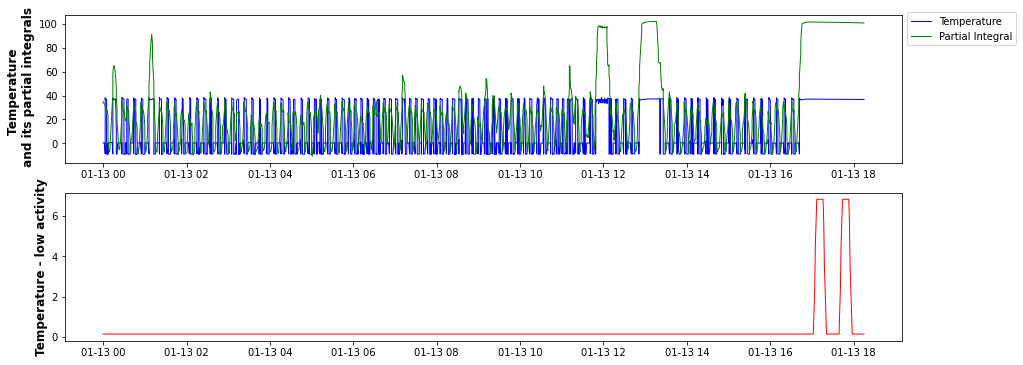

In [150]:
plots = 2


fig, ax = plt.subplots(plots, 1, figsize=(15,6), squeeze=False)
cnt = 0
ax[cnt,0].plot(df_inputm3.index, df_inputm3[Temperature],linewidth=1,color='blue',label=Temperature)
ax[cnt,0].plot(df_inputm3.index, df_inputm3['Quad']/4,linewidth=1,color='green',label='Partial Integral')
ax[cnt,0].legend(bbox_to_anchor=(1.0, 1.05))
ax[cnt,0].set_ylabel('Temperature \n and its partial integrals',fontsize=12,weight="bold")
cnt = 1
ax[cnt, 0].plot(df_inputm3.index, df_inputm3[spectralinv], linewidth=1,color='red', label='Low Activity')
ax[cnt, 0].set_ylabel('Temperature - low activity',fontsize=12,weight="bold")


### Turning preparation, evaluation and visualization into functions

In [301]:
def prepData(fileName):
    # Run on the good pump first 
    # Get stuff in
    df_i = pd.read_csv(fileName, index_col=False, parse_dates=['t_stamp'])
    #t_stamp,CA1/CDA/AC_Comp1/InterCoolTemp

    entity_name = [x for x in df_i.columns if not x.startswith('t_stamp')][0]
    entity_name_ = entity_name.replace('/','_')

    df_i['entity']=entity_name_  # NO SLASHES IN FILESYSTEM !
    df_i.rename(columns={'t_stamp':'timestamp', entity_name:'Temperature'}, inplace=True)

    # and sort it by timestamp
    df_i = df_i.sort_values(by='timestamp')
    df_i = df_i.set_index(['entity','timestamp']).dropna()

    return df_i

def runSpectral(df_i):
    jobsettings = { 'db': db, 
                   '_db_schema': 'public', 'save_trace_to_file' : True}

    spsi = SpectralAnomalyScoreExt(Temperature, 12, spectral, spectralinv)
    et = spsi._build_entity_type(columns = [Column(Temperature,Float())], **jobsettings)
    spsi._entity_type = et
    df_i = spsi.execute(df=df_i)
    return df_i

def computeL2Deriv(df_i, winsize):
    df_m = df_i.reset_index().set_index('timestamp')

    # partial L2-norm of 1st derivative
    temperature = df_m[Temperature].values
    slices_ = skiutil.view_as_windows(temperature, window_shape=(winsize,), step=1)

    Dslice_list = []
    for slice in slices_:
        Dslice_list.append(sp.linalg.norm(np.diff(slice)))
    DSlice = np.asarray(Dslice_list)

    #stretch it
    time_series_temperature = np.linspace(winsize // 2, temperature.size - winsize // 2 - 1, DSlice.size)

    temp_dl2_inter = sp.interpolate.interp1d(time_series_temperature, DSlice,
                                              kind='linear', fill_value='extrapolate')
    df_m['Fluctuation'] = temp_dl2_inter(np.arange(0, temperature.size))
    return df_m
    
def plotData(df_i, label, title, scale=[1,100,1]):
    df_m = df_i.reset_index().set_index('timestamp')
    plots = 1

    fig, ax = plt.subplots(plots, 1, figsize=(15,10), squeeze=False)
    cnt = 0
    if scale[0] > 0:
        ax[cnt,0].plot(df_m.index, df_m[Temperature]/scale[0],linewidth=1,color='blue',label=label)
    if scale[1] > 0:
        ax[cnt,0].plot(df_m.index, df_m[spectral]/scale[1], linewidth=1, color='orange', label='Anomalous Activity')
    if scale[2] > 0:
        ax[cnt,0].plot(df_m.index, df_m[spectralinv]/scale[2], linewidth=1, color='red', label='Low Activity')
    ax[cnt,0].legend(bbox_to_anchor=(1.0, 1.05))
    ax[cnt,0].set_ylabel(title,fontsize=12,weight="bold")
    
    


### Discharge Temperature

2021-01-22T11:36:02.017 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.


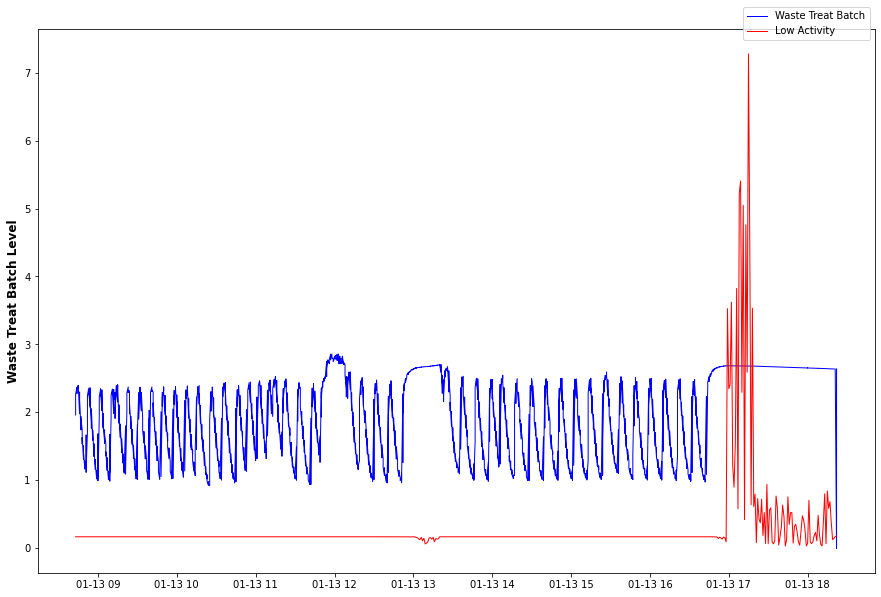

In [272]:
df = prepData('./AI_Data/Discharge_Temp.csv')
df = runSpectral(df)
plotData(df, 'Waste Treat Batch', 'Waste Treat Batch Level', [100, 0, 1]) # scale data, ignore spectral

### Transfer Tank Level

2021-01-22T13:56:35.579 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.


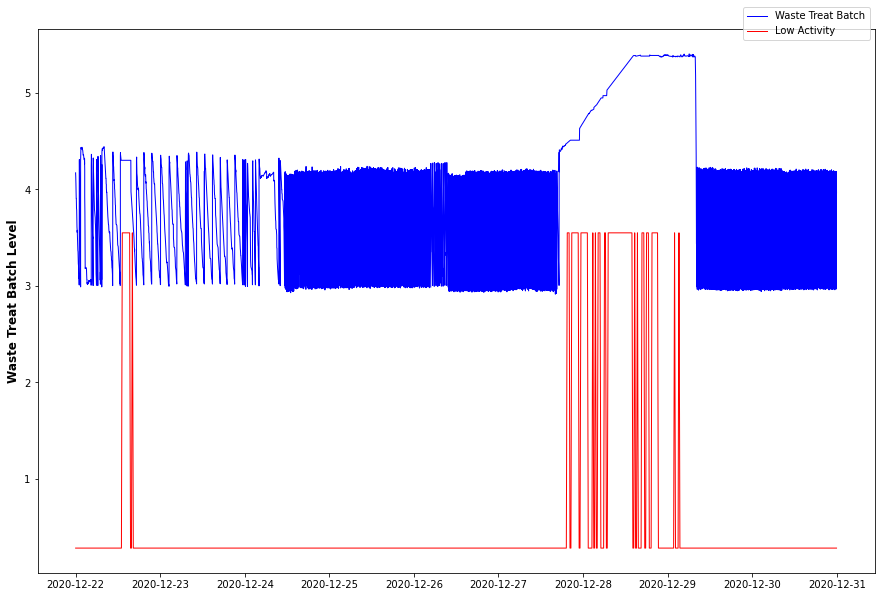

In [309]:
df = prepData('./AI_Data/Transfer Tank Level.csv')
df = runSpectral(df)
plotData(df, 'Waste Treat Batch', 'Waste Treat Batch Level', [15, 0, 1]) # scale data, ignore spectral

#### Investigating distribution based anomaly scoring

/home/markus/.local/lib/python3.8/site-packages/seaborn/distributions.py:1181: UserWarning: The following kwargs were not used by contour: 'rug'
  cset = contour_func(


Text(0.5, 1.0, 'Bivariate KDE - temperature and fluctuation')

<Figure size 576x288 with 0 Axes>

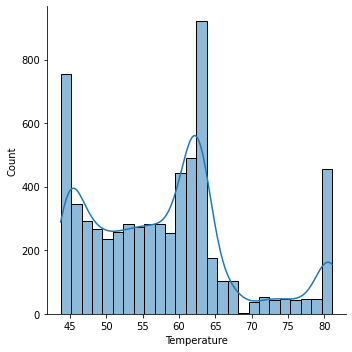

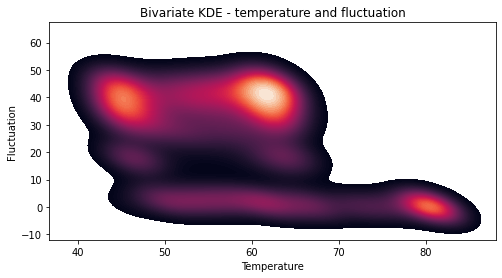

In [311]:
import seaborn as sns

df_m4 = computeL2Deriv(df, 20)  # Compute 'wiggliness'

plt.figure(figsize=(8,4))
g1 = sns.displot(data=df['Temperature'], kde=True)

plt.figure(figsize=(8,4))
g2 = sns.kdeplot(
    data=df_m4, x='Temperature', y='Fluctuation', fill=True, thresh=0.02, levels=100, cmap="rocket", rug=True
)
g2.set_title('Bivariate KDE - temperature and fluctuation')

#### The probability distribution of temperature

is nowhere close to an element of $\mathcal{N}(\mu,\sigma)$. With the anomaly at ~80 degrees removed we
would see a bimodal distribution peaking at 63, resp. 45 degrees.

<img src='./samples/probability_distribution_assumption.jpg' height="120x" width="250x">

It's multimodal, so approximating it with Gaussians or any other unimodal distribution won't do.

But we can still set up KDE based anomaly detection.


### ISW Supply Pressure

2021-01-22T11:41:57.590 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.


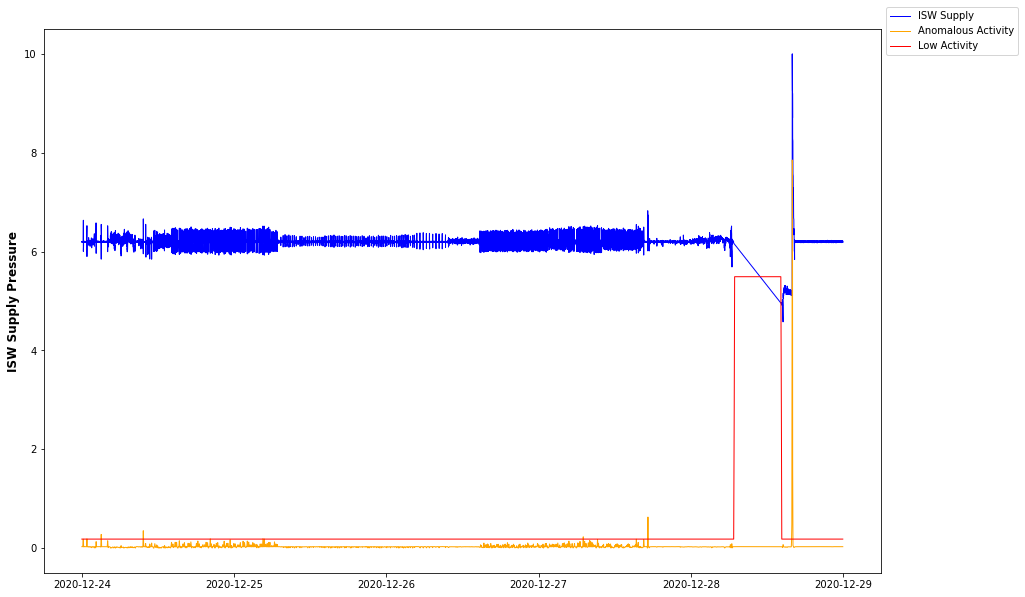

In [284]:
df = prepData('./AI_Data/ISW Supply Pressure.csv')
df = runSpectral(df)
plotData(df, 'ISW Supply', 'ISW Supply Pressure', [10, 150, 1]) # scale data


### Exhaust Scrubber pH

2021-01-22T11:44:04.791 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.


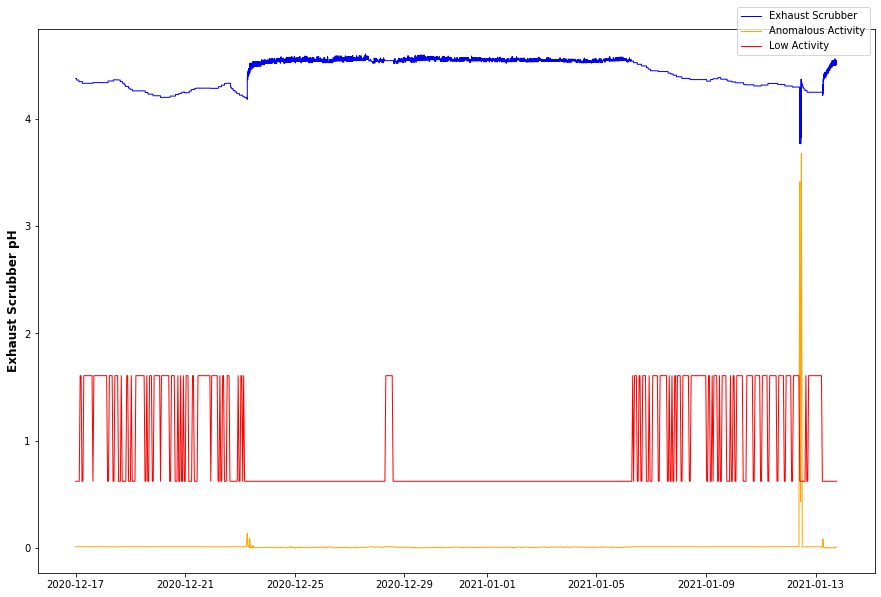

In [289]:
df = prepData('./AI_Data/Exhaust Scrubber pH.csv')
df = runSpectral(df)
plotData(df, 'Exhaust Scrubber', 'Exhaust Scrubber pH', [2, 200, 1]) # scale data


### Hot Water Supply Gauge Pressure

2021-01-22T11:45:41.430 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.


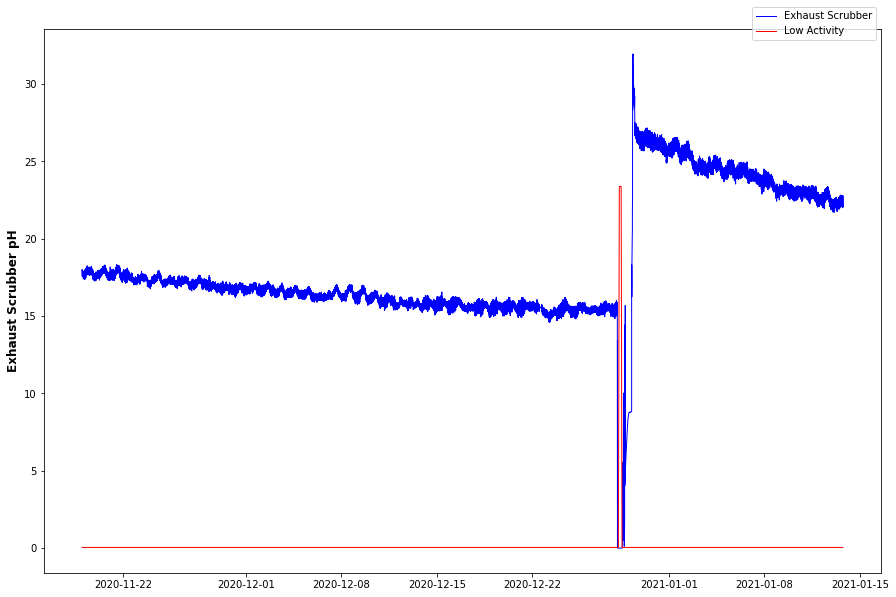

In [293]:
df = prepData('./AI_Data/Hot Water Supply Gauge Pressure.csv')
df = runSpectral(df)
plotData(df, 'Exhaust Scrubber', 'Exhaust Scrubber pH', [2, 0, 1]) # scale data


### Waste Treat Batch Tank HF-T-1

#### Results for Waste Batch Levels

Spectral indicates peaks that are normal so it's not a useful indicator here

2021-01-22T11:19:29.884 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.


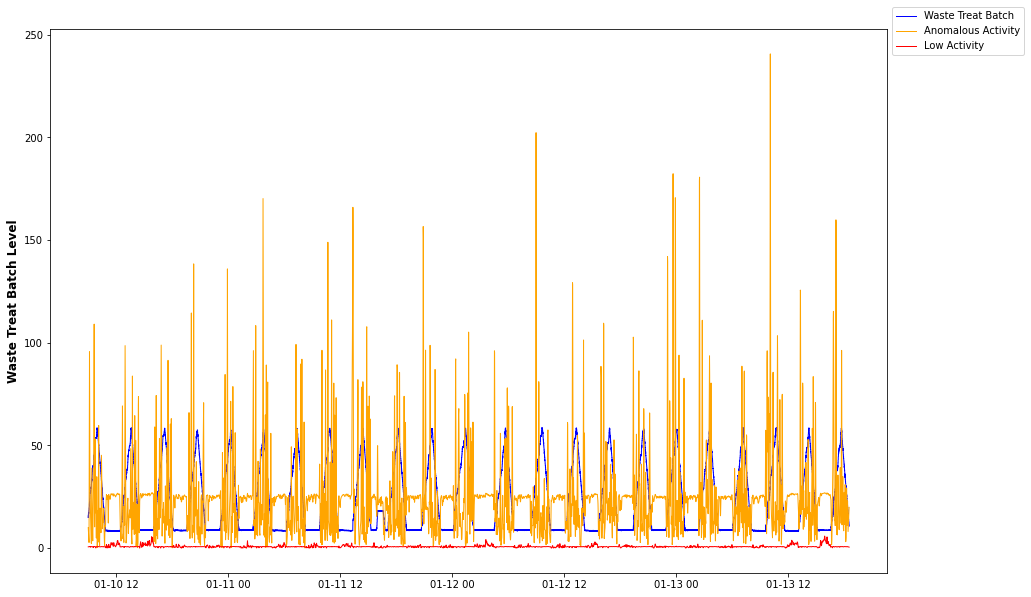

In [249]:
df = prepData('./AI_Data/Waste Treat Batch Tank HF-T-1.csv')
df = runSpectral(df)
plotData(df, 'Waste Treat Batch', 'Waste Treat Batch Level', [100, 1, 1])

### HF Waste Treat RT-1 pH

2021-01-22T16:40:07.005 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.


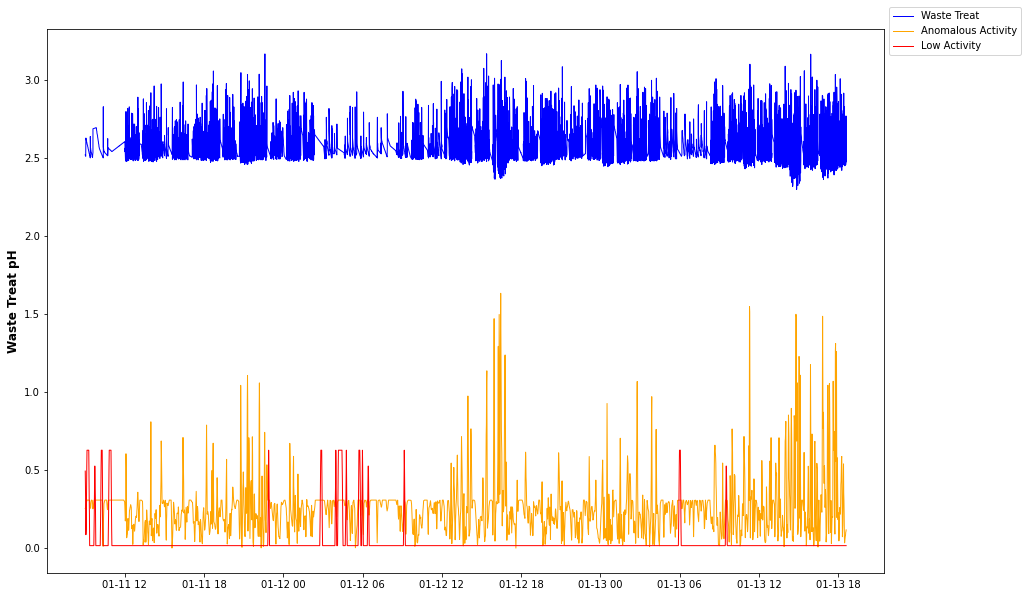

In [341]:

df = prepData('./AI_Data/HF Waste Treat RT-1 pH.csv')
df = runSpectral(df)
plotData(df, 'Waste Treat', 'Waste Treat pH', [3,100, 10] )

#### Digression: Again we look at the probability distribution of the data (pH)

Text(0.5, 1.0, 'Bivariate KDE - temperature and fluctuation')

<Figure size 360x216 with 0 Axes>

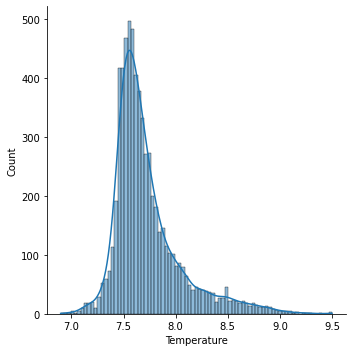

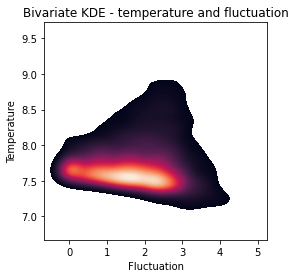

In [347]:
df_m = computeL2Deriv(df, 20)
plt.figure(figsize=(5,3))
g1 = sns.displot(data=df['Temperature'], kde=True)

plt.figure(figsize=(4,4))
g2 = sns.kdeplot(
    data=df_m, x='Fluctuation', y='Temperature', fill=True, thresh=0.05, levels=100, cmap="rocket"
)
g2.set_title('Bivariate KDE - temperature and fluctuation')

#### Data "outside" should be considered a true outlier 

makes more sense if we have a true relationship between input (features) and output variables (targets)

2021-01-22T17:16:44.182 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
Here 1 <class 'pandas.core.frame.DataFrame'>
['Fluctuation']
2021-01-22T17:16:44.193 INFO iotfunctions.dbtables.retrieve_model Model model.TEST_ENTITY_FOR_KDEANOMALYSCORE.KDEAnomalyScore.Temperature.CA3_ContFluoride_RT1_pH of size 105346 bytes has been retrieved from filesystem
2021-01-22T17:16:44.195 INFO mmfunctions.anomaly.execute load model KDE instance
Number of variables: k_vars = 2
Number of samples:   nobs = 6551
Variable types:      cc
BW selection method: normal_reference



<ipython-input-350-2e45a8c69b4e>:11: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  ax[0,0].scatter(df['Fluctuation'], df[Temperature], c=df['pred'], s=10, edgecolor='', cmap='viridis')


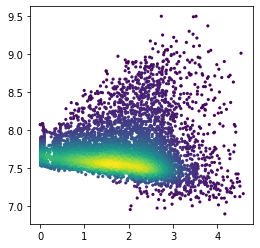

In [350]:

jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

df['Fluctuation'] = df_m['Fluctuation'].values.T
kdei = KDEAnomalyScore(0.05, ['Fluctuation'], [Temperature], ['pred']) # percentage threshold is not yet implemented
et = kdei._build_entity_type(columns = [Column(Temperature,Float())], **jobsettings)
kdei._entity_type = et
df = kdei.execute(df=df)

fig, ax = plt.subplots(1, 1, figsize=(4, 4), squeeze=False)
ax[0,0].scatter(df['Fluctuation'], df[Temperature], c=df['pred'], s=10, edgecolor='', cmap='viridis')


### Fume Scrubber 1 Ref pH

2021-01-22T14:00:29.024 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.


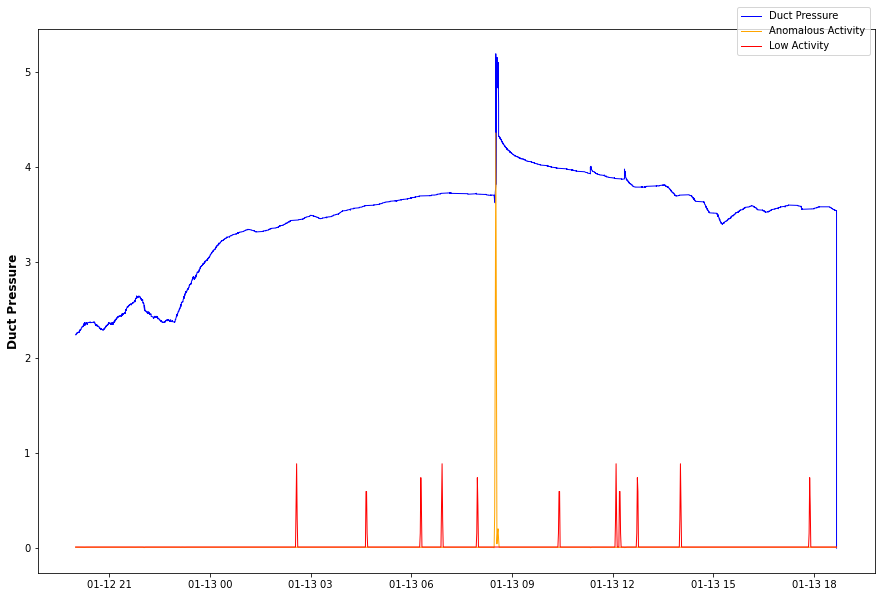

In [316]:

df = prepData('./AI_Data/Fume Scrubber 1 Ref 
              pH.csv')
df = runSpectral(df)
plotData(df, 'Duct Pressure', 'Duct Pressure', [2,200, 10] )

### FS-6 Duct Pressure

Low activity peaks are artifacts (because I'm avoiding a divide-by-zero error), anomalous activity peaks where it should

2021-01-22T13:48:00.299 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.


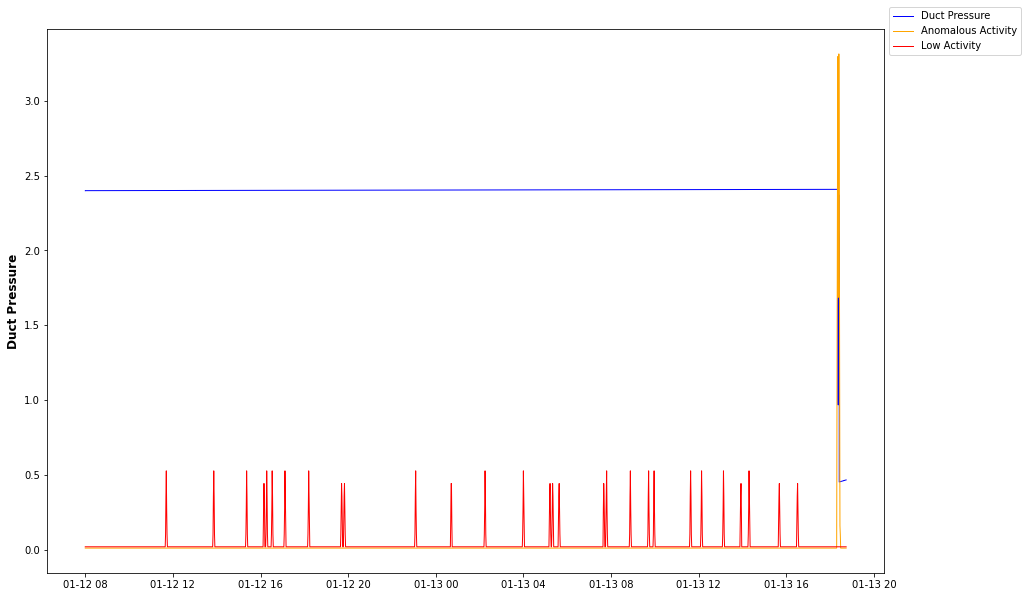

In [296]:
df = prepData('./AI_Data/FS-6 Duct Pressure.csv')
df = runSpectral(df)
plotData(df, 'Duct Pressure', 'Duct Pressure', [2,200, 10] )

#### GMM doesn't work 

trying with 

In [122]:
from sklearn.mixture import BayesianGaussianMixture

nr_comp = 5

nn = 90000
xy1 = np.vstack([df_m4['Fluctuation'], df_m4['Temperature']]).T

#xy1 = np.vstack([df_m4['Fluctuation'], df_m4['Temperature']]).T
#idx11 = np.argsort(-1 * z1)[1:nn]

#print (xy1[idx11].shape, xy1.shape)


BGM = BayesianGaussianMixture(n_components=nr_comp, verbose=1, n_init=12,
                              init_params='random', weight_concentration_prior_type='dirichlet_distribution',
                              covariance_type='full')
BGM.fit(xy1)

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
  Iteration 80
  Iteration 90
  Iteration 100
Initialization converged: False
Initialization 1
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
  Iteration 80
  Iteration 90
  Iteration 100
Initialization converged: False
Initialization 2
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
  Iteration 80
  Iteration 90
  Iteration 100
Initialization converged: True
Initialization 3
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
  Iteration 80
  Iteration 90
  Iteration 100
Initialization converged: True
Initialization 4
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
  Iteration 80
  Iteration 90
  Iteration 100
Initialization converged: True
Ini

BayesianGaussianMixture(init_params='random', n_components=5, n_init=12,
                        verbose=1,
                        weight_concentration_prior_type='dirichlet_distribution')

In [117]:
Y = BGM.predict_proba(xy1)
BGM.mean_prior_

array([26.09730185, 57.95225062])

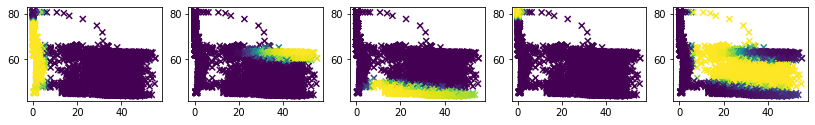

In [125]:
plt.figure(figsize=(14,10))
for i in range(nr_comp):
    plt.subplot(nr_comp,nr_comp,i+1)
    plt.scatter(df_m4['Fluctuation'],df_m4['Temperature'],
                c=BGM.predict_proba(xy1)[:nn-1,i],cmap='viridis',marker='x')

In [ ]:
# Run on the good pump first 
# Get stuff in
df_i3 = pd.read_csv('./AI_Data/Transfer Tank Level.csv', index_col=False, parse_dates=['t_stamp'])
#t_stamp,CA1/CDA/AC_Comp1/InterCoolTemp


df_i3['entity']='CA3E_SWS_LIT2103_EU'  # NO SLASHES IN FILESYSTEM !
df_i3.rename(columns={'t_stamp':'timestamp', 'CA3E/SWS/LIT2103/EU':'Temperature'}, inplace=True)

# and sort it by timestamp
df_i3 = df_i3.sort_values(by='timestamp')
df_i3 = df_i3.set_index(['entity','timestamp']).dropna()

df_i3

In [20]:
# nothing of interest below ... ;-)